# Behavioral Patterns

The behavioral patterns are guidelines suggested to create classes that allows to communicate objects to each other. The goal of the behavioral patterns is to make those interactions easier and more understandable.

The five creational patterns available are:
1. Chain of Responsability
2. Command
3. Iterator
4. Mediator
5. Memento
6. Observer
7. State
8. Strategy
9. Template method
10. Visitor

Again, we are going to be convering eaach of the possible patterns and making some examples in the context of machine learning engineering.

# Strategy

**What is a strategy?**

This is design pattern that allows to create a manager class that uses objects from different classes that performs different actions, but those actions are done similarly accross the different classes. Thus, those classes can be used interchangeably. 

**When should we use it?**

This design pattern is suggested when a class have different options to perform a similar task. If the user needs a modification, instead of creating a big-class with several `if/else` statements. It allows to inject a client class that knows how to perform the actions.

**Analogy:**

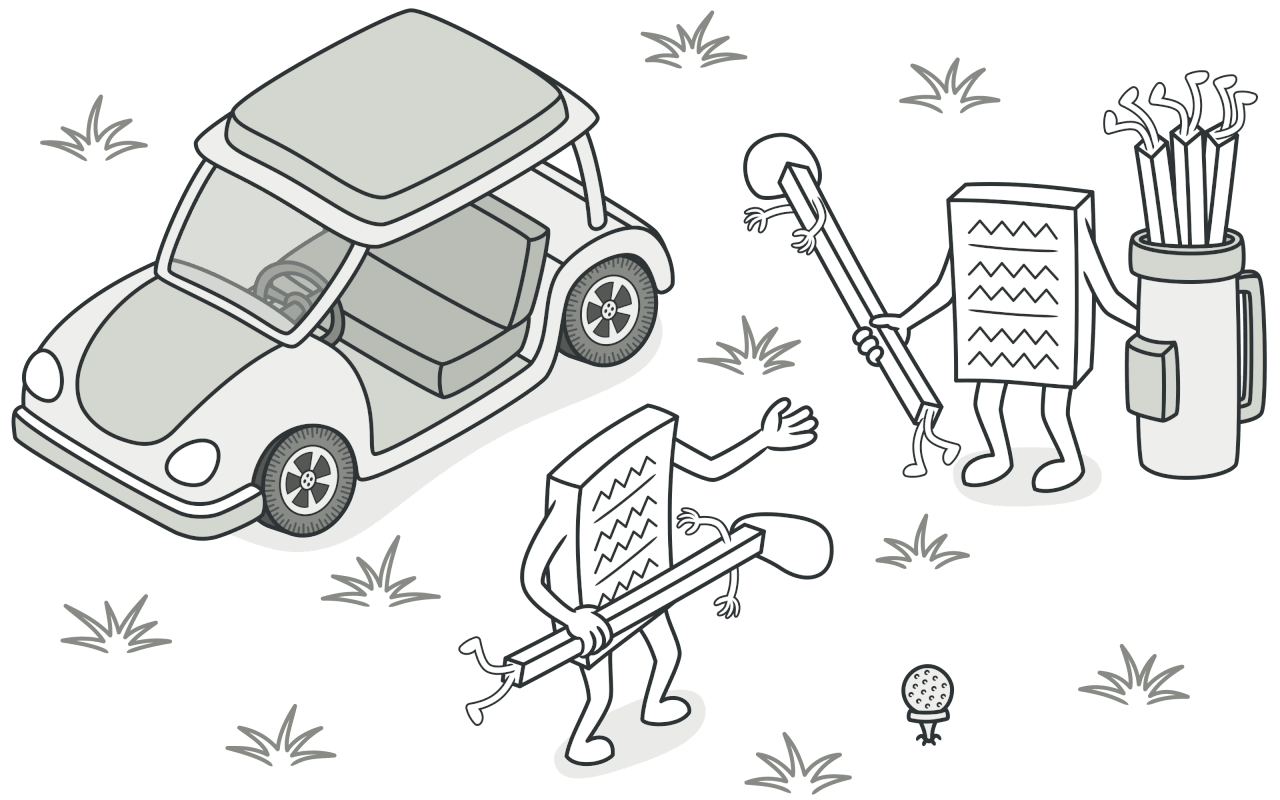

**Reference:** https://refactoring.guru/design-patterns/strategy

**Scenario**

You're a machine learning engineer creating an autoprocessing class to scale data. Several people in your team are suggesting that the technique used in the scaling process might lead to different results. Please create a piece of code that performs different scaling techniques. It must do a MinMaxScaler, StandardScaler, or a RobustScaler.

In [17]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from abc import ABC

import pandas as pd

In [7]:
df = load_diabetes(as_frame=True, return_X_y=True)

In [8]:
df = pd.concat([df[0], df[1]], axis=1)

## Antipattern

A simple way to do this is creating a simple class that performs the data processing. Inside this class, we can have different methods for each possible scaler. The scaler choosen can be executed given an string with a `if/else` statement.

In [11]:
class DataScaler:
    def __init__(self):
        self.scaler = None

    def _process_minmax_scaler(self, df: pd.DataFrame) -> pd.DataFrame:
        self.scaler = MinMaxScaler()
        scaled_data = self.scaler.fit_transform(df)
        return pd.DataFrame(scaled_data, columns=df.columns)

    def _process_standard_scaler(self, df: pd.DataFrame) -> pd.DataFrame:
        self.scaler = StandardScaler()
        scaled_data = self.scaler.fit_transform(df)
        return pd.DataFrame(scaled_data, columns=df.columns)

    def _process_robust_scaler(self, df: pd.DataFrame) -> pd.DataFrame:
        self.scaler = RobustScaler()
        scaled_data = self.scaler.fit_transform(df)
        return pd.DataFrame(scaled_data, columns=df.columns)

    def transform(self, df: pd.DataFrame, technique: str) -> pd.DataFrame:
        if technique not in ["standard", "minmax", "robust"]:
            raise ValueError(f"Unknown scaling technique: {technique}")

        df = df.copy()

        if technique == "minmax":
            return self._process_minmax_scaler(df)
        elif technique == "standard":
            return self._process_standard_scaler(df)
        elif technique == "robust":
            return self._process_robust_scaler(df)

Let's try this class

In [12]:
data_processor = DataScaler()

Apply the min_max, standard, and robust scalers

In [13]:
data_minmax = data_processor.transform(df, technique="minmax")

In [14]:
data_standard = data_processor.transform(df, technique="standard")

In [15]:
data_robust = data_processor.transform(df, technique="robust")

However, the class breakes some important principles. 

1. It breakes the single responsability principle because different scaling techniques are created in the same class.
2. Adding more code is a mess, so it breakes the open-closed principle.
3. It breakes the inferface segregation principle because the class have methods that it does not being used.
4. Also, the dependency inversion principle is broken because the bigger class contains logic of the child classes.

**How to solve the antipattern?**

1. Create a data processor manager class that uses a client from other class for the processing.
2. Define the client class with similar functionalities to be injected into the manager class.
3. A class should be created for each possible functionality.

## Pattern

In [19]:
class DataManager:
    def __init__(self, client):
        self.client = client
        self.scaler = None

    def handle(self, df: pd.DataFrame) -> pd.DataFrame:
        result = self.client.transform(df)
        self.scaler = self.client.scaler
        return result

Create the base class for each of client processor class

In [20]:
class BaseProcessor(ABC):
    def __init__(self):
        self.scaler = None

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        pass

Define the child class for the MinMaxScaler, Standard Scaler, and the Robust Scaler

In [28]:
class MinMaxProcessor(BaseProcessor):
    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        self.scaler = MinMaxScaler()
        return pd.DataFrame(self.scaler.fit_transform(df), columns=df.columns)


class StandardProcessor(BaseProcessor):
    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        self.scaler = StandardScaler()
        return pd.DataFrame(self.scaler.fit_transform(df), columns=df.columns)


class RobustProcessor(BaseProcessor):
    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        self.scaler = RobustScaler()
        return pd.DataFrame(self.scaler.fit_transform(df), columns=df.columns)

Let's try with this new implementation

In [29]:
data_manager_minmax = DataManager(MinMaxProcessor())

In [30]:
result_minmax = data_manager_minmax.handle(df)

Try the standard scaler

In [32]:
data_manager_standard = DataManager(StandardProcessor())

In [33]:
result_standard = data_manager_standard.handle(df)

Try the robust scaler

In [34]:
data_manager_robust = DataManager(RobustProcessor())
result_robust = data_manager_robust.handle(df)

As you see previously, the manager class allows to reduce the depencency of the methods available. Besides, it reduces the dependency and allows to inject any scaler technique we might have.